In [1]:
# @title .
%%html
<style>
.uline {
    text-decoration: underline;
    text-decoration-color: #0013fc;
    text-decoration-thickness: 2px;
}

.uline:hover {
    transition: color 0.25s, background-color 0.25s;
    background-color: #0013fc;
    transition-timing-function: ease-in;
    color: white;
}
</style>

In [2]:
import os

if not os.path.exists('/content/utility'):
    os.mkdir('utility')

else:
    print("Folder exists")


!cp '/content/drive/MyDrive/Projects/Google Data Scientist/scripts/Utility Scripts/project_ml.py' '/content/utility'
!cp "/content/drive/MyDrive/Projects/Google Data Scientist/dataset/hr_data.csv" "/content"
!cp "/content/drive/MyDrive/Projects/Google Data Scientist/scripts/confusion_matrix/cf_matrix.py" "/content"

In [3]:
!pip install pyjanitor==0.19.0 icecream sweetviz patchworklib shap --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.1/15.1 MB 34.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.2/48.2 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.3 MB/s eta 0:00:00


# <font color='#0013fc'>Google Advance Analytics Capstone</font>
---

## About the company
Salifort Motors is a fictional French-based <font class='uline'>alternative energy vehicle manufacturer</font>. Its global workforce of over 100,000 employees research, design, construct, validate, and distribute electric, solar, algae, and hydrogen-based vehicles. Salifort’s end-to-end vertical integration model has made it a global leader at the intersection of alternative energy and automobiles.        

## Business case
As a data specialist working for Salifort Motors, you have received the results of a recent employee survey. The senior leadership team has tasked you with analyzing the data to come up with ideas for how <font class='uline'>to increase employee retention.</font> To help with this, they would like you to design a model that predicts whether an employee will leave the company based on their  department, number of projects, average monthly hours, and any other data points you deem helpful.

## Scenario

Currently, there is a high rate of turnover among Salifort employees. (Note: In this context, turnover data includes both employees who choose to quit their job and employees who are let go). Salifort’s senior leadership team is concerned about how many employees are leaving the company. Salifort strives to create a corporate culture that supports employee success and professional development.

>Further,the high turnover rate is costly in the financial sense. Salifort makes a big investment in recruiting, training, and upskilling its employees.

If Salifort could predict whether an employee will leave the company, and discover the reasons behind their departure, they could better understand the problem and develop a solution.

As a first step, the leadership team asks Human Resources to survey a sample of employees to learn more about what might be driving turnover.  

Next, the leadership team asks you to analyze the survey data and come up with ideas for how to increase employee retention. To help with this, they suggest you design a model that predicts whether an employee will leave the company based on their job title, department, number of projects, average monthly hours, and any other relevant data points.

> A good model will help the company increase retention and job satisfaction for current employees, and save money and time training new employees.

As a specialist in data analysis, the leadership team leaves it up to you to choose an approach for building the most effective model to predict employee departure.

For any approach, you’ll need to analyze the key factors driving employee turnover, build an effective model, and share recommendations for next steps with the leadership team.

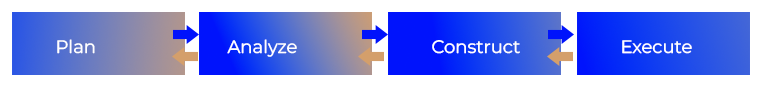

##  Plan
---
This project aims to solve the business needs of Salifort by exploring the data and building a machine learning model that will be able to predict employees who are likely to exit. The increasing employee turnover marks as a problem as hiring and interviewing candidates can be expensive. Being in a such a competitive industry, identifying the factors leading to employee turnover will help the Salifort in the long run.

|Column Name|Type|Description
|---|---|---|
|satisfaction_level|int64|The employee’s self-reported satisfaction level [0-1]
|last_evaluation|int64|Score of employee's last performance review [0–1]
|number_project|int64|Number of projects employee contributes to
|average_monthly_hours|int64|Average number of hours employee worked per month
|time_spend_company|int64|How long the employee has been with the company (years)
|work_accident|int64|Whether or not the employee experienced an accident while at work
|left|int64|Whether or not the employee left the company
|promotion_last_5years|int64|Whether or not the employee was promoted in the last 5 years
|department|str|The employee's department
|salary|str|The employee's salary (low, medium, or high)

## Analyze

In [4]:
import utility.project_ml as pml
from cf_matrix import make_confusion_matrix

from typing import List
from collections.abc import Iterator

import pandas as pd
import numpy as np
import janitor
import janitor.ml
import pandas_flavor as pf
import warnings
import sweetviz as sv
from plotnine import *
import plotly.express as px
import patchworklib as pw
import matplotlib.pyplot as plt
from scipy.stats import describe

from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import plot_tree, DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from imblearn.combine import SMOTEENN
from imblearn.under_sampling import EditedNearestNeighbours

from sklearn.metrics import precision_score, accuracy_score, recall_score,\
     f1_score, confusion_matrix, classification_report, silhouette_score

from xgboost import XGBClassifier
from xgboost import plot_importance

import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = 100
pd.options.display.max_colwidth = 50
%matplotlib inline

/content/utility/project_ml.py:148: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if model_name is 'SupportVectorClassifier' or 'LogisticRegression':


<Figure size 100x100 with 0 Axes>

In [5]:
hr = pd.read_csv('hr_data.csv')
# report = sv.analyze(hr)
# report.show_html()

# set copy of original data
original_df = hr.copy(deep=True)
df = original_df.drop_duplicates()

In [6]:
df.dtypes

satisfaction_level       float64
last_evaluation          float64
number_project             int64
average_montly_hours       int64
time_spend_company         int64
Work_accident              int64
left                       int64
promotion_last_5years      int64
Department                object
salary                    object
dtype: object

In [7]:
df = df\
    .clean_names()\
    .rename_columns(
        {'average_montly_hours': 'avg_monthly_hours','left': 'exit'})\
    .encode_categorical(column_names=['department', 'salary'])

### Model Preperation

In [8]:
# selecting features DV, IV
X, y = df.get_features_targets(target_column_names='exit')

# store different types in variables
numerical_features = X.select_dtypes('number')
categorical_features = X.select_dtypes('category')

# store column names
num_feat_names = numerical_features.columns.to_list()
cat_feat_names = categorical_features.columns.to_list()

# make column transformer
transformer = make_column_transformer(
    (StandardScaler(), num_feat_names),
    (OneHotEncoder(sparse=False), cat_feat_names))

# fit features into transformer
fit_ct = transformer.fit(X)
X_transformed = fit_ct.transform(X)

# get ohe featurenames
ohe_col_names = fit_ct.named_transformers_['onehotencoder']\
    .get_feature_names_out()

# add ohe feature names to num feature names
all_feature_names = num_feat_names
all_feature_names.extend(list(ohe_col_names))

# create finished dataframe
X_CT = pd.DataFrame(X_transformed, columns=all_feature_names)

# # Fixed variables for our models
TRAIN_SPLIT = 0.75
M_RN_STATE = 2

# train test split
X_train, X_test, y_train, y_test = train_test_split(
    X_CT, y,
    train_size=TRAIN_SPLIT,
    random_state=M_RN_STATE)

### Feature Selection


In [9]:
# creeate a classification dict
classification_model = {
    'DecisionTreeClassifier': DecisionTreeClassifier(random_state=M_RN_STATE),
    'RandomForestClassifier' : RandomForestClassifier(random_state=M_RN_STATE),
    'SupportVectorClassifier': SVC(kernel='linear', random_state=M_RN_STATE),
    'LogisticRegression': LogisticRegression(random_state=M_RN_STATE)}

In [10]:
# create an empty feature importance dict
m_feature_importance = dict()
pml.train_models(
    classification_model,
    [X_train, X_test, y_train, y_test],
    m_feature_importance,
    all_feature_names)


        Model: DecisionTreeClassifier --------------------
        f1-score: 89.91
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      2493
           1       0.89      0.91      0.90       505

    accuracy                           0.97      2998
   macro avg       0.94      0.94      0.94      2998
weighted avg       0.97      0.97      0.97      2998


        Model: RandomForestClassifier --------------------
        f1-score: 94.85
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      2493
           1       0.99      0.91      0.95       505

    accuracy                           0.98      2998
   macro avg       0.99      0.95      0.97      2998
weighted avg       0.98      0.98      0.98      2998


        Model: SupportVectorClassifier --------------------
        f1-score: 0.0
              precision    recall  f1-score   support

           0       0.83      1.00      0

In [11]:
# transform feature importance data into dataframe
df_importance = [pd.DataFrame(data)
    for data in pml.get_table_feature_importance(m_feature_importance)]

# create a table of feature importance with classification anmes
table_feat_importance = [frame.set_index('feature')\
        .rename_columns({'importance': f'{name}'})\
        for frame, name in zip(df_importance, classification_model.keys())]

# style the table values
table_feat_importance = pd.concat(
    table_feat_importance, axis=1)\
    .style.background_gradient(cmap='viridis')

# export data as html
# table_feat_importance.to_html('feat_importance.html')

**Synthesis**<br>
The Logistic and SVM models chose similar features in importance. Both assigned
a low salary as the main predictor for an exit. In comparison to the tree and ensemble model, both assigned satisfaction level as the likely predictors of exit.

Decision Tree and RandomForest gave little importance to wether
which department an employee belongs or the level of their salary.
The list of features that are of high importance of both models are of the following:

**What features are important for both Tree & Ensemble Models?**
*   Satisfaction level
*   Last performance evaluation
*   Number of projects
*   Time spent in the company
*   Average monthly hours

### Unsupervised Machine Learning

In [12]:
# select important features from ensemble models
important_features = df.select_dtypes('number').iloc[:, :-3]
scaled_features = StandardScaler().fit_transform(important_features)
scaled_important_features = pd.DataFrame(scaled_features, columns=important_features.columns)

# use elbow method to decide for number of clusters
num_clusters = [i for i in range(2, 11)]
inertia = pml.kmeans_inertia(num_clusters, scaled_important_features)

In [13]:
inertia_plot = px.line(x=num_clusters, y=inertia)\
    .update_layout(template='plotly_white', width=800, height=480,
                   title='<b>Elbow Method</b> / n_clusters=1-10')\
    .update_traces(marker={'color': 'black'})

inertia_plot

In [14]:
sil_score = pml.kmeans_sil(num_clusters, scaled_important_features)
sil_plot = px.line(x=num_clusters, y=sil_score)\
    .update_layout(template='plotly_white', width=800, height=480,
                  title='<b>Silhouette Score line</b> / n_clusters=1-10')\

sil_plot

In [15]:
# KMeans clusters of 2 (0, 1, 2)
km3 = KMeans(n_clusters=3, random_state=4).fit(scaled_important_features)
scaled_important_features['clusters'] = km3.labels_

feat_to_plot = ["last_evaluation", "avg_monthly_hours", "number_project", "time_spend_company"]
plot_collection = [pml.plot_kmean_feat(i, scaled_important_features) for i in feat_to_plot]

plot_g = [pw.load_ggplot(plot, figsize=(5,3)) for plot in plot_collection]
plot_mat_g = ((plot_g[0]|plot_g[1])/(plot_g[2]|plot_g[3]))

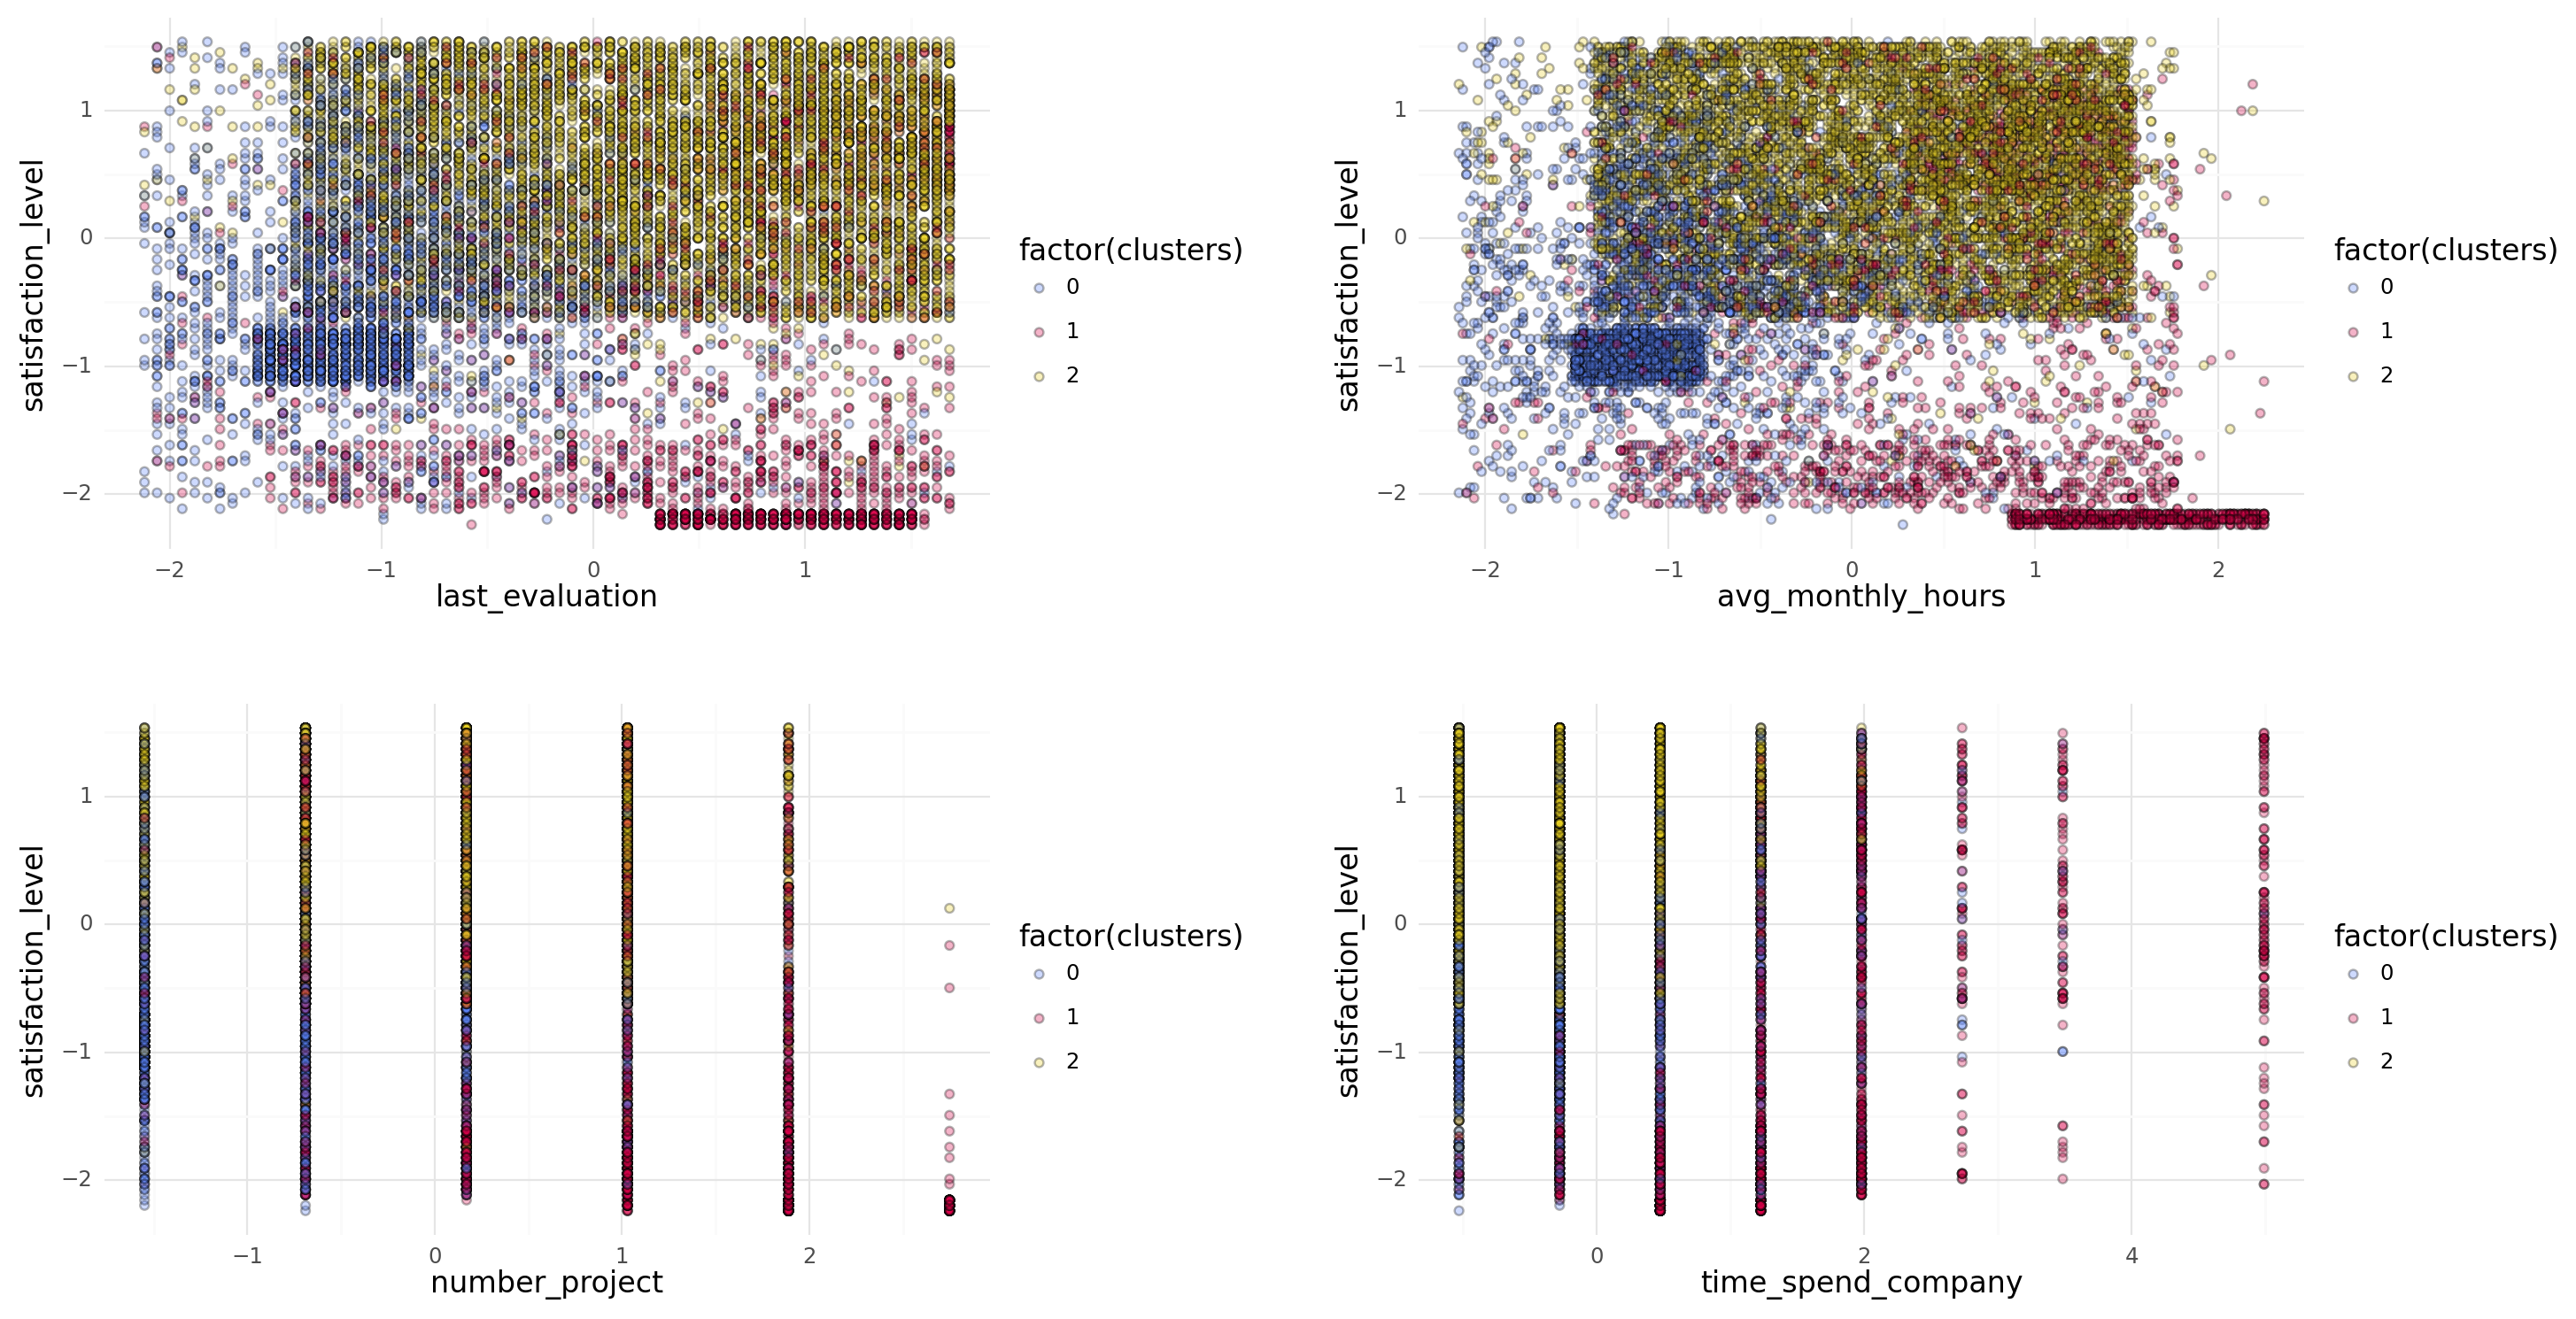

In [16]:
plot_mat_g

**Class Imblanace**


In [17]:
np.round(y.value_counts(normalize=True) * 100, 2)

0    83.4
1    16.6
Name: exit, dtype: float64

The decision tree and ensemble model performed well in labeling our y-class `exit` with an f-1 score of 90 and 95 respectively. With that in mind, let's evaluate the potential effects of Type I and Type II error in the business of Sarifort.

- **Type I**: False Positive <br>
Not likely to exit but labelled as to exit.
    - Financial cost on added training
    - Retainment cost

- **Type II**: False Negative <br>
Likey to exit but labelled as likely to stay.
    - Time gap for replacing lost position.
        - Adding more work load to other employees during time gap.
    - Financial cost of hiring
    

### Boosting Models

**XGBoost**

In [18]:
xgb = XGBClassifier(objective='binary:logistic', random_state=M_RN_STATE)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=2, ...)

In [19]:
@pf.register_dataframe_method
def get_base_metrics(df, y_test, y_pred) -> pd.DataFrame:
    """
    :description:
        ...
    :y_test: Test data from training split
    :y_test type: array
    :y_pred: Predict data from model
    :y_pred type: array
    :returns: Dataframe with model metrics score.
    """
    return df.assign(base_f1_score=[f1_score(y_test, y_pred)])\
        .assign(base_recall_score=[recall_score(y_test, y_pred)])\
        .assign(base_precision_score=[precision_score(y_test, y_pred)])\
        .assign(base_accuracy_score=[accuracy_score(y_test, y_pred)])

In [20]:
# predict test data
y_pred = xgb.predict(X_test)

# store score in dataframe
base_model_score = pd.DataFrame()
base_model_score.get_base_metrics(y_test, y_pred)

base_f1_score  base_recall_score  base_precision_score  base_accuracy_score
0        0.95082           0.918812              0.985138             0.983989

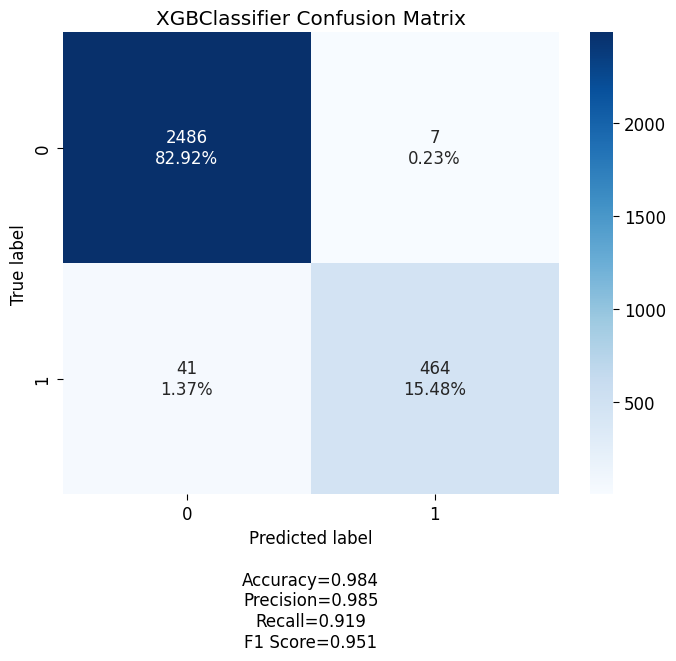

In [21]:
cm = confusion_matrix(y_test, y_pred, labels=xgb.classes_)
make_confusion_matrix(cm, figsize=(8,6),
    title='XGBClassifier Confusion Matrix')

**AdaptiveBoost**

In [22]:
ad = AdaBoostClassifier(random_state=M_RN_STATE)
ad.fit(X_train, y_train)

AdaBoostClassifier(random_state=2)

In [23]:
ada_boost_metrics = pd.DataFrame()
ada_y_pred = ad.predict(X_test)
ada_boost_metrics.get_base_metrics(y_test, ada_y_pred)

base_f1_score  base_recall_score  base_precision_score  base_accuracy_score
0       0.884848           0.867327              0.903093             0.961975

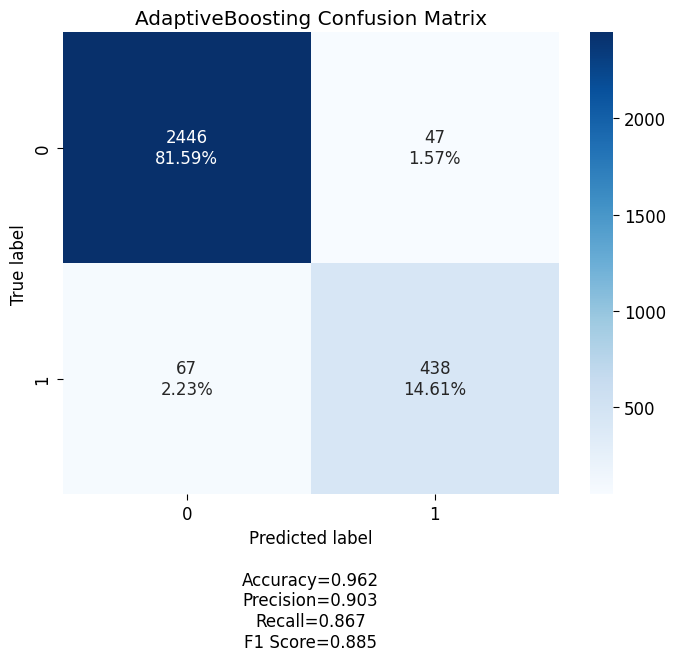

In [24]:
cm = confusion_matrix(y_test, ada_y_pred, labels=ad.classes_)
make_confusion_matrix(cm, figsize=(8,6),
    title='AdaptiveBoosting Confusion Matrix')

**ROC-AUC Curve Visualization**

In [25]:
from sklearn.metrics import roc_curve, roc_auc_score

In [26]:
transformed_list = [X_train, X_test, y_train, y_test]

# create a classification dict
classification_model = {
    'DecisionTreeClassifier' : DecisionTreeClassifier(
        random_state=M_RN_STATE),
    'RandomForestClassifier' : RandomForestClassifier(
        random_state=M_RN_STATE),
    'AdaptiveBoost': AdaBoostClassifier(
        random_state=M_RN_STATE),
    'XGBoostClassifier': XGBClassifier(
        random_state=M_RN_STATE)}

In [27]:
clm_auc_roc_score = {k: '' for k in classification_model.keys()}

In [28]:
def get_roc_auc(y_test: pd.Series, model_name: str,
split: List, score_dict: dict,) -> pd.DataFrame:
    """
    :param str model_name: String of model names to be used.
    :param list split: Split data from train_test_split().
    :param dict score_dict: Empty dictionary with model names.
    :returns: Pandas DataFrame for Plotting.
    """
    model = classification_model[model_name].fit(split[0], split[2])
    model_pred = model.predict_proba(split[1])[:, 1]
    y_test_array = y_test.to_numpy()

    # get auc scores
    false_pos_r, true_pos_r, thresh = roc_curve(y_test, model_pred, pos_label=1)
    auc_roc_df = pd.DataFrame([false_pos_r, true_pos_r]).T
    auc_roc_df.columns = ['fpr', 'tpr']
    auc_roc_df['model_name'] = model_name
    score_dict[model_name] = roc_auc_score(y_test_array, model_pred)


    return auc_roc_df

In [29]:
# prepare model dataframe probability for roc auc

roc_auc_dt = get_roc_auc(y_test, 'DecisionTreeClassifier',
    transformed_list, clm_auc_roc_score)

roc_auc_rfc = get_roc_auc(y_test, 'RandomForestClassifier',
    transformed_list, clm_auc_roc_score)

roc_auc_ada = get_roc_auc(y_test, 'AdaptiveBoost',
    transformed_list, clm_auc_roc_score)

roc_auc_xgb = get_roc_auc(y_test, 'XGBoostClassifier',
    transformed_list, clm_auc_roc_score)

In [30]:
# concat dataframes for plotting
roc_auc_all_models = [roc_auc_dt, roc_auc_rfc, roc_auc_ada, roc_auc_xgb]
roc_auc_all_models_df = pd.concat(roc_auc_all_models, axis=0)

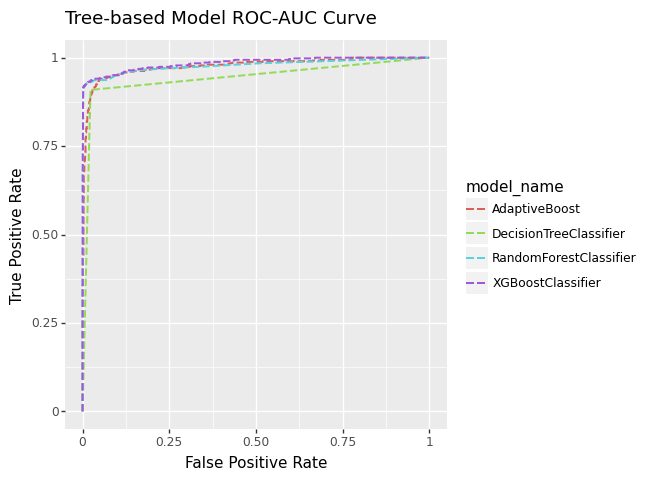

<Figure Size: (640 x 480)>

In [31]:
ggplot() + geom_line(roc_auc_all_models_df,
    aes(x='fpr', y='tpr', color='model_name'),size=0.8, linetype='dashed')\
    + ggtitle('Tree-based Model ROC-AUC Curve')\
    + labs(x='False Positive Rate', y='True Positive Rate')

The tree based models are performing well in our ROC-AUC curve. On the other hand, the decision-tree classifier performing less than the other models and will not proceed to tuning.

**The models that we'll be using for tuning hyperparameters**

- random forest classifier,
- xgboost,
- adaptive boost.

And compare their performance in unknown data (f1-score).

## GridSearch CV

In [32]:
import pickle
from sklearn.model_selection import GridSearchCV

#### GridSearchCV

XGBoost Classifier

In [33]:
# xgboost parameters
params = {
    'n_estimators': [200, 350, 500, 800],
    'learning_rate': [0.01, 0.15, 0.3],
    'max_depth': [3, 5],
    'min_child_weight': [3, 5, 10],
    'subsample': [0.3, 0.7],
    'alpha': [1, 2]
}

# scoring
scoring = {'accuracy', 'precision', 'recall', 'f1', 'roc_auc'}

# xgboost model
xgbc = XGBClassifier(random_state=M_RN_STATE)

In [34]:
# gridsearch for xgbc
gcv_xgboost = GridSearchCV(
    xgbc,
    params,
    scoring=scoring,
    refit='f1')

In [35]:
# %%time
# gcv_xgboost.fit(X_train, y_train)

# # dump model
# with open('xgbcv.pickle', 'wb') as f:
#     pickle.dump(gcv_xgboost, f)

# !cp "/content/xgbcv.pickle" "/content/drive/MyDrive/Projects/Google Data Scientist/models"

In [36]:
!cp "/content/drive/MyDrive/Projects/Google Data Scientist/models/xgbcv.pickle" "/content"
with open('xgbcv.pickle', 'rb') as pickle_f:
    gcv_xgboost = pickle.load(pickle_f)

In [37]:
gcv_xgboost.best_params_

{'alpha': 2,
 'learning_rate': 0.01,
 'max_depth': 5,
 'min_child_weight': 3,
 'n_estimators': 800,
 'subsample': 0.7}

In [38]:
gcv_xgboost.best_score_

0.9414281714476669

Random Forest Classifier

In [39]:
# random forest classifier
# params = {
#     'n_estimators': [200, 350, 500, 800],
#     'min_samples_split': [.1, .2, .3, .4, .5],
#     'max_depth': [None, 2, 5, 7, 10],
#     'min_samples_leaf': [.1, .2, .3, .4, .5],
#     'class_weight': ["balanced"],
# }

params = {
    'max_depth': [5, 6, 7],
    'max_features': [1.0],
    'max_samples': [0.7],
    'min_samples_leaf': [1,2],
    'min_samples_split': [2,3],
    'n_estimators': [50, 100],
    }

# scoring
scoring = {'accuracy', 'precision', 'recall', 'f1', 'roc_auc'}

# xgboost model
rfc = RandomForestClassifier(random_state=M_RN_STATE)

In [40]:
# gridsearch for xgbc
gcv_rfc = GridSearchCV(
    rfc,
    params,
    scoring=scoring,
    refit='f1')

In [41]:
# %%time
# gcv_rfc.fit(X_train, y_train)

# # dump model
# with open('rfc.pickle', 'wb') as f:
#     pickle.dump(gcv_rfc, f)

# !cp "/content/rfc.pickle" "/content/drive/MyDrive/Projects/Google Data Scientist/models"

In [42]:
!cp "/content/drive/MyDrive/Projects/Google Data Scientist/models/rfc.pickle" "/content"
with open('rfc.pickle', 'rb') as pickle_f:
    gcv_rfc = pickle.load(pickle_f)

In [43]:
gcv_rfc.best_params_

{'max_depth': 7,
 'max_features': 1.0,
 'max_samples': 0.7,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 100}

In [44]:
gcv_rfc.best_score_

0.9502917250538034

### Hyperoptimization for XGBoost and RandomForest

col_sample_bytree : Fraction of features (columns) used for building each tree. It introduces randomness by selecting a subset of features for each tree.

Base XGBoost Parameters:
* n_estimators: 100
* max_depth: 6
* learning_rate: 0.3
* subsample: 1.0
* colsample_bytree: 1.0
* colsample_bylevel: 1.0
* gamma: 0
* min_child_weight: 1
* lambda (L2 regularization term): 1
* alpha (L1 regularization term): 0
* scale_pos_weight: 1
*  objective: "binary:logistic" (for binary classification)

In [45]:
from sklearn.model_selection import StratifiedKFold
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
from hyperopt.pyll.base import scope
from functools import partial
from sklearn.metrics import roc_auc_score

In [46]:
params = {
    # tree based hyperparameters
    'n_estimators': scope.int(hp.quniform('n_estimators', 100, 200, 10)),
    'colsample_bytree': hp.quniform('colsample_bytree', 0.5, 1, 1),
    'learning_rate': hp.quniform('learning_rate', .3, .5, .1),

    # imbalanced hyperparam
    'scale_pos_weight': hp.quniform('scale_pos_weight', 1.5, 10.0, .5)
    }

In [47]:
def optimize(params: dict, x, y):

    classifier = XGBClassifier(**params) # model
    kf = StratifiedKFold(n_splits=5) # splits
    roc_auc_score_list = []

    for index in kf.split(x, y):

        train_index, test_index = index[0], index[1]
        x_train = x[train_index]
        y_train = y[train_index]

        x_test = x[test_index]
        y_test = y[test_index]

        classifier.fit(x_train, y_train)
        pred = classifier.predict(x_test)

        roc_auc = roc_auc_score(y_test, pred)
        roc_auc_score_list.append(roc_auc)

    return -1.0 * np.mean(roc_auc_score_list)


In [48]:
opt_func = partial(
    optimize, x=X_CT.values,
    y=y.values)

In [49]:
trials = Trials()
result = fmin(
    opt_func,
    algo=tpe.suggest,
    space=params,
    max_evals=15
)

print(result)

100%|██████████| 15/15 [00:18<00:00,  1.21s/trial, best loss: -0.9576291866601176]
{'colsample_bytree': 1.0, 'learning_rate': 0.30000000000000004, 'n_estimators': 130.0, 'scale_pos_weight': 5.0}


## SHAP

In [50]:
best_model = XGBClassifier(
    colsample_bytree=1.0, learning_rate=0.3, n_estimators=120, scale_pos_weight=8.0,
    objective='binary:logistic', num_classes=2)

In [51]:
best_model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=120, n_jobs=None, num_classes=2,
              num_parallel_tree=None, ...)

In [52]:
best_model.fit(X_train, y_train)
pred = best_model.predict(X_test)

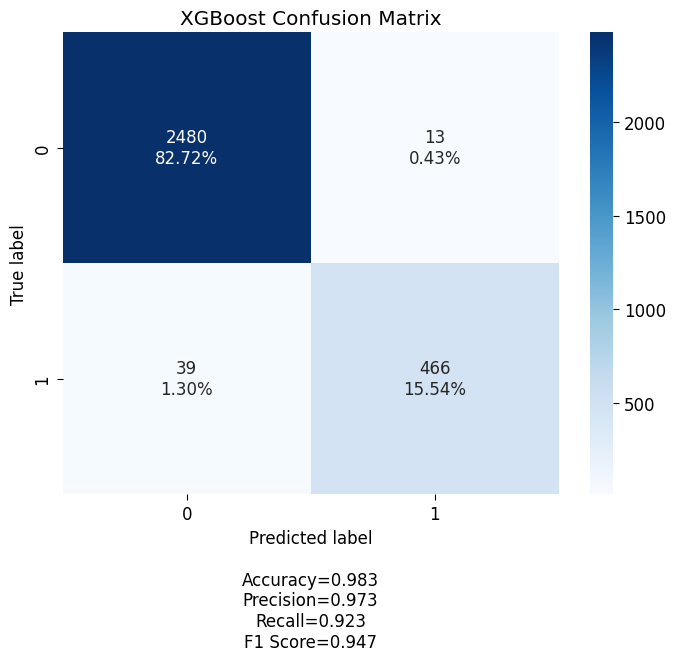

In [53]:
cm = confusion_matrix(y_test, pred, labels=best_model.classes_)
make_confusion_matrix(cm, figsize=(8,6),
    title='XGBoost Confusion Matrix')

In [ ]:
import shap

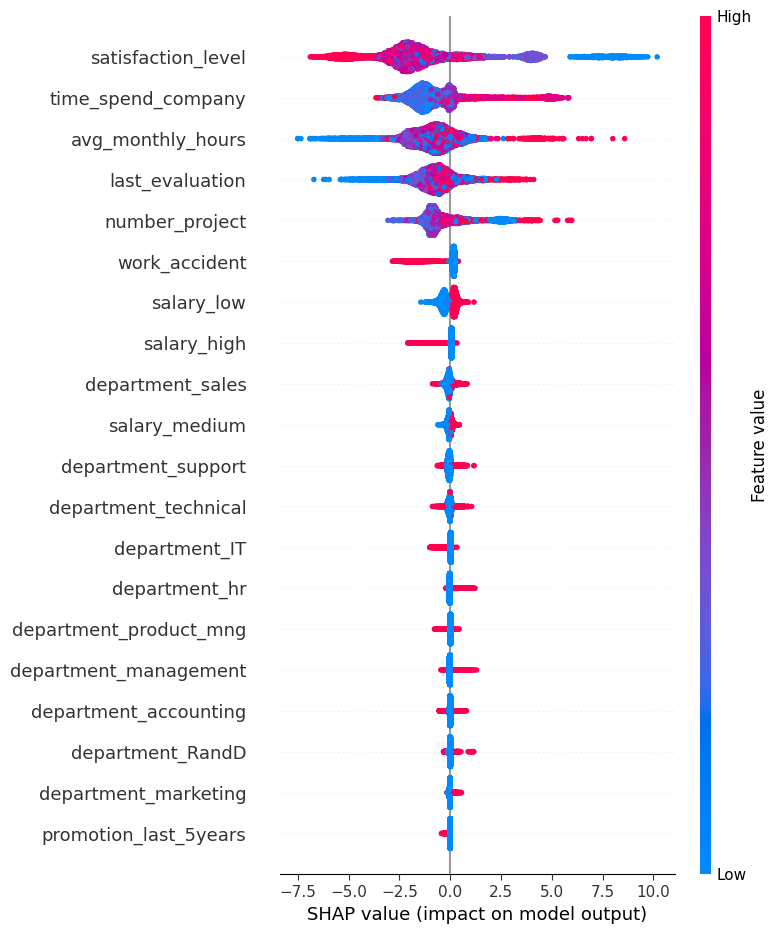

In [ ]:
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train)